In [1]:
%matplotlib inline
import quimb as qu
import quimb.tensor as qtn

In [2]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = {'KET'}

ket = qtn.Tensor(data, inds, tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags={'KET'})

In [3]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags={'PAULI', 'X', '0'})
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags={'PAULI', 'Y', '1'})

And finally, a random 'bra' to complete the inner product:

In [4]:
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags={'BRA'})

In [5]:
TN = ket.H & X & Y & bra
print(TN)

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags={'KET'}),
    Tensor(shape=(2, 2), inds=('k0', 'b0'), tags={'X', 'PAULI', '0'}),
    Tensor(shape=(2, 2), inds=('k1', 'b1'), tags={'Y', 'PAULI', '1'}),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags={'BRA'}),
])


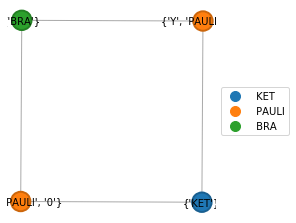

In [6]:
TN.graph(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4))

Note the tags can be used to identify both paulis at once. But they could also be uniquely identified using their ``'X'`` and ``'Y'`` tags respectively:

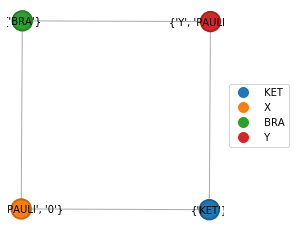

In [7]:
TN.graph(color=['KET', 'X', 'BRA', 'Y'], figsize=(4, 4))

In [8]:
TN ^ all

(-0.06293658935292364+0.763177999610807j)

Or if we just want to contract the paulis:

In [9]:
print(TN ^ 'PAULI')

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags={'KET'}),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags={'BRA'}),
    Tensor(shape=(2, 2, 2, 2), inds=('k0', 'b0', 'k1', 'b1'), tags={'PAULI', '0', 'Y', 'X', '1'}),
])


Notice how the ``tags`` of the Paulis have been combined on the new tensor.

The contraction order is optimized automatically using ``opt_einsum``, is cached,
and can easily handle hundreds of tensors (though it uses a greedy algorithm and 
is not guaranteed to find the optimal path).

A cumulative contract allows a custom 'bubbling' order:

In [10]:
# "take KET, then contract X in, then contract BRA *and* Y in, etc..."
print(TN >> ['KET', 'X', ('BRA', 'Y')])

(-0.06293658935292364+0.763177999610807j)


And a structured contract uses the tensor networks tagging structure (a string
format specifier like ``"I{}"``) to perform a cumulative contract automatically, 
e.g. grouping the tensors of a MPS/MPO into segments of 10 sites.
This can be slightly quicker than finding the full contraction path.

When a TN has a structure, structured contractions can be used by specifying either an ``Ellipsis``:

    ``TN ^ ...``  # which means full, structured contract

or a ``slice``:

    ``TN ^ slice(100, 200)``  # which means a structured contract of those sites only

In [11]:
print((TN ^ 'PAULI'))

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags={'KET'}),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags={'BRA'}),
    Tensor(shape=(2, 2, 2, 2), inds=('k0', 'b0', 'k1', 'b1'), tags={'PAULI', '0', 'Y', 'X', '1'}),
])


In [12]:
# select any tensors matching the 'KET' tag - here only 1
Tk = TN['KET']

# now split it, creating a new tensor network of 2 tensors
Tk_s = Tk.split(left_inds=['k0'])

# note new index created 
print(Tk_s)

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', '_76028b0000008'), tags={'KET'}),
    Tensor(shape=(2, 2), inds=('_76028b0000008', 'k1'), tags={'KET'}),
])


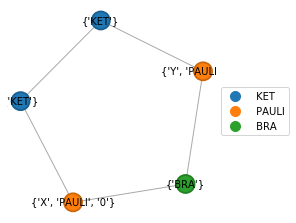

In [13]:
# remove the original KET tensor
del TN['KET']

# inplace add the split tensor network
TN &= Tk_s

# plot - should now have 5 tensors
TN.graph(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4))

In [14]:
# make a 5 qubit tensor state
dims = [2] * 5
data = qu.rand_ket(32).A.reshape(*dims)
inds=['k0', 'k1', 'k2', 'k3', 'k4']
psi = qtn.Tensor(data, inds=inds)

# find the inner product with itself
psi.H @ psi

1.0

In this case, the conjugated copy ``psi.H`` has the same outer indices as ``psi`` and so the inner product is naturally formed.